In [ ]:
import torch
import torchaudio
import torchvision.transforms as transforms
from torchvision.models import vgg16
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")

data = np.load("hvcm/RFQ.npy", allow_pickle=True)
label = np.load("hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

scaled_data = MinMaxScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

normal_indices = np.where(label == 0)
anomalous_indices = np.where(label == 1)


cuda
NVIDIA A100-PCIE-40GB
(872, 4500, 14) (872,)


# Processing: Mel Spec > Resizing > Feature Extraction

In [ ]:
# Resize and convert to 3-channel image
def resize_spectrogram(spectrogram):
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-6)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

# Process dataset
def process_dataset(data):
    num_samples, _, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=2500000, n_mels=128).to(device)
    model = vgg16(pretrained=True).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()ß

    for i in range(num_samples):
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            img = resize_spectrogram(mel)
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    return features

features = process_dataset(data)
print("Features shape:", features.shape)

/home/chris/GANs/.venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/home/chris/GANs/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chris/GANs/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Features shape: (872, 14, 4096)


# Train-Test split

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.2, random_state=42)


# AE Training

In [ ]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 100), nn.ReLU(),
            nn.Linear(100, 50), nn.ReLU(),
            nn.Linear(50, 25), nn.ReLU(),
            nn.Linear(25, 12), nn.ReLU(),
            nn.Linear(12, 6), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(6, 12), nn.ReLU(),
            nn.Linear(12, 25), nn.ReLU(),
            nn.Linear(25, 50), nn.ReLU(),
            nn.Linear(50, 100), nn.ReLU(),
            nn.Linear(100, input_size), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))



# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=256):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model


def print_eval(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
  print("F1 = {}".format(f1_score(labels, predictions)))
  print(confusion_matrix(labels, predictions))

# Plot reconstruction error histogram
def plot_reconstruction_error(model, features, percentile=95):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    errors = []
    criterion = nn.MSELoss(reduction='none')

    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            batch_errors = criterion(outputs, inputs).mean(dim=1)
            errors.extend(batch_errors.cpu().numpy())

    threshold = np.percentile(errors, percentile)
    anomalies = np.sum(np.array(errors) > threshold)

    plt.hist(errors, bins=50, alpha=0.75)
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({percentile}%)')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Reconstruction Error Histogram')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Anomaly threshold: {threshold:.6f}")
    print(f"Detected anomalies: {anomalies}")

model = train_autoencoder(features[normal_indices], epochs=50, batch_size=128)


Epoch 1/50, Loss: 0.890475
Epoch 2/50, Loss: 0.666888
Epoch 3/50, Loss: 0.666663
Epoch 4/50, Loss: 0.666547
Epoch 5/50, Loss: 0.666442
Epoch 6/50, Loss: 0.666426
Epoch 7/50, Loss: 0.666324
Epoch 8/50, Loss: 0.666198
Epoch 9/50, Loss: 0.666122
Epoch 10/50, Loss: 0.665849
Epoch 11/50, Loss: 0.665637
Epoch 12/50, Loss: 0.665485
Epoch 13/50, Loss: 0.665228
Epoch 14/50, Loss: 0.664869
Epoch 15/50, Loss: 0.664558
Epoch 16/50, Loss: 0.664281
Epoch 17/50, Loss: 0.664170
Epoch 18/50, Loss: 0.664059
Epoch 19/50, Loss: 0.663989
Epoch 20/50, Loss: 0.663853
Epoch 21/50, Loss: 0.663850
Epoch 22/50, Loss: 0.663629
Epoch 23/50, Loss: 0.663528
Epoch 24/50, Loss: 0.663220
Epoch 25/50, Loss: 0.662756
Epoch 26/50, Loss: 0.661299
Epoch 27/50, Loss: 0.660140
Epoch 28/50, Loss: 0.659939
Epoch 29/50, Loss: 0.659856
Epoch 30/50, Loss: 0.659724
Epoch 31/50, Loss: 0.659675
Epoch 32/50, Loss: 0.658853
Epoch 33/50, Loss: 0.658262
Epoch 34/50, Loss: 0.657997
Epoch 35/50, Loss: 0.657665
Epoch 36/50, Loss: 0.657700
E

# Plot

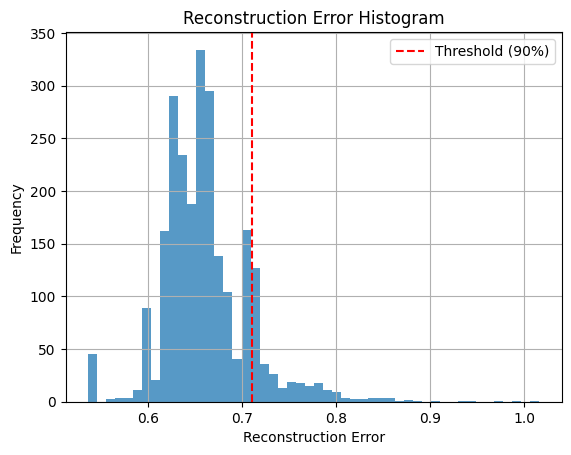

Anomaly threshold: 0.710655
Detected anomalies: 245


In [90]:
percentile = 90

plot_reconstruction_error(model, test_data, percentile=percentile)


# Evaluation

In [ ]:

# Compute reconstruction errors
x = model(torch.tensor(test_data.reshape(-1, 4096), dtype=torch.float32).to(device)).cpu().detach().numpy()
errors = np.mean((x - test_data.reshape(-1, 4096)) ** 2, axis=1)

# Reshape to (175, 14)
errors = errors.reshape(test_data.shape[0], test_data.shape[1])

# Aggregate per sample (e.g., mean across channels)
sample_errors = np.mean(errors, axis=1)

# Thresholding
threshold = np.percentile(sample_errors, percentile)
predictions = (sample_errors > threshold).astype(int)

# Now you can compare with test_labels
print_eval(predictions, test_labels)


Accuracy = 0.8742857142857143
Precision = 0.8888888888888888
Recall = 0.4444444444444444
F1 = 0.5925925925925926
[[137   2]
 [ 20  16]]
